# Homework 11 (20pt)

In this assignment, you will apply an MLP/FFN (remember, multilayer perceptron and fully connected neural network mean the same thing) for handwritten digit recognition.

__Do not__ use datasets with preprocessed images in NumPy or Torch formats. You can either upload the data to Google Drive and mount it in Colab (so, you don't need to upload it every time), or download it manually from:  
https://www.kaggle.com/datasets/playlist/mnistzip/

Submit your Jupyter notebook, the saved model weights, and the images from the last question. You may submit multiple files or a single archived (e.g., `.zip`) file.


### Q1 (1pt) Download MNIST dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

zip_path = '/content/drive/My Drive/MLP_MNIST/archive.zip'
extract_path = '/content/mnist_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:", os.listdir(extract_path))

Extracted files: ['mnist_png']


In [20]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_dir = '/content/mnist_data/mnist_png'

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Q2 (2pt) Create Train and Validation Dataset and DataLoader objects

In [21]:
# Load train and validation datasets directly
train_dataset = datasets.ImageFolder(root='/content/mnist_data/mnist_png/train', transform=transform)
val_dataset = datasets.ImageFolder(root='/content/mnist_data/mnist_png/valid', transform=transform)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### Q3 (4pt) Define the model: the number of hidden layers and their size/dimentions. Make sure you are using __more than one hidden layer__

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(28 * 28, 256)  # input → hidden layer 1
        self.fc2 = nn.Linear(256, 128)      # hidden layer 1 → hidden layer 2
        self.fc3 = nn.Linear(128, 64)       # hidden layer 2 → hidden layer 3
        self.output = nn.Linear(64, 10)     # hidden layer 3 → output (10 classes)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))   # ReLU after each layer
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.output(x)        # No softmax here (use CrossEntropyLoss)
        return x

### Q4 (4pt) Write the training loop. Use accuracy as the metric on the Validation set. You can use early stopping or just observe the validation curve

In [28]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    avg_loss = running_loss / len(val_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

Epoch 1/20
Train Loss: 0.4002, Train Accuracy: 87.54%
Val Loss: 0.1950, Val Accuracy: 94.14%
Epoch 2/20
Train Loss: 0.1699, Train Accuracy: 94.70%
Val Loss: 0.1394, Val Accuracy: 95.77%
Epoch 3/20
Train Loss: 0.1240, Train Accuracy: 96.13%
Val Loss: 0.1388, Val Accuracy: 95.62%
Epoch 4/20
Train Loss: 0.1016, Train Accuracy: 96.80%
Val Loss: 0.1030, Val Accuracy: 96.80%
Epoch 5/20
Train Loss: 0.0873, Train Accuracy: 97.21%
Val Loss: 0.1047, Val Accuracy: 96.64%
Epoch 6/20
Train Loss: 0.0752, Train Accuracy: 97.59%
Val Loss: 0.0934, Val Accuracy: 97.02%
Epoch 7/20
Train Loss: 0.0658, Train Accuracy: 97.93%
Val Loss: 0.0945, Val Accuracy: 96.93%
Epoch 8/20
Train Loss: 0.0613, Train Accuracy: 97.98%
Val Loss: 0.0858, Val Accuracy: 97.22%
Epoch 9/20
Train Loss: 0.0565, Train Accuracy: 98.14%
Val Loss: 0.0879, Val Accuracy: 97.42%
Epoch 10/20
Train Loss: 0.0499, Train Accuracy: 98.36%
Val Loss: 0.0864, Val Accuracy: 97.42%
Epoch 11/20
Train Loss: 0.0411, Train Accuracy: 98.62%
Val Loss: 0.07

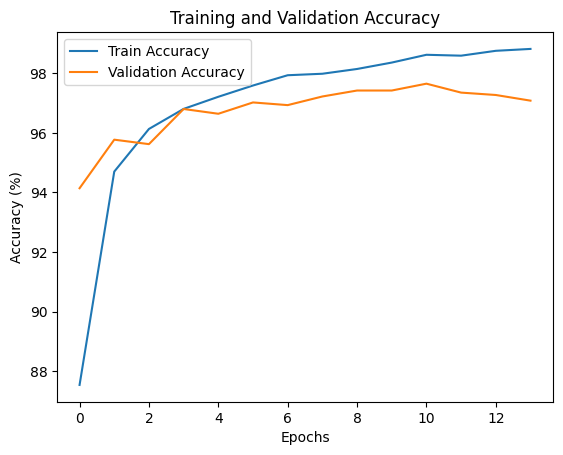

In [29]:
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 20
patience = 3  # Early stopping patience (stop if no improvement for 3 epochs)

# Initialize variables to track progress
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_accuracy = 0
epochs_without_improvement = 0

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Training phase
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print("Early stopping triggered")
        break

# Plotting training and validation accuracy curves
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

### Q5 (2pt) Plot the training loss and validation accuracy. You can use Tensorboard

### Q6 (3pt) Calculate the accuracy on the validation set. __It should be > 0.97__

### Q7 (4pt) Create three images, one with a digit not in the middle, and apply your trained model to them